# Hackathon

Some utilities

## Import Utils

In [2]:
!pip install --upgrade pip

    100% |################################| 1.4MB 1.1MB/s eta 0:00:01
  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1


In [3]:
!pip install keras

    100% |################################| 337kB 3.3MB/s eta 0:00:01
    100% |################################| 256kB 4.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml


In [4]:
import keras
import h5py as h5
import numpy as np

PATH_DATA = 'half.h5'
PATH_PREDICT_WITHOUT_GT = 'pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT = 'pred_eighties_from_half_1_AWESOMEGROUP.h5'
PATH_PREDICT_WITH_GT = 'pred_eighties_from_half_1.h5'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [6]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [7]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = f['S2'][batch_idxs, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [8]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

In [9]:
train_gen = generator(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [10]:
print(train_batch_count, val_batch_count)

233728 58432


# Instanciation du model

In [11]:
input_shape = (16,16,4)
model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Flatten())
model.add(Dense(23))
model.add(Activation('softmax'))

In [12]:
from keras.models import Model
from keras.layers import Input, Conv3D, Conv2D, Dropout, MaxPooling2D, Flatten, Activation

inp = Input(shape = input_shape)

x = Conv2D(32, (3,3))(inp)
x = BatchNormalization(axis=-1)(x)
x = Activation("relu")(x)
x = Conv2D(32, (3,3))(x)
x = BatchNormalization(axis=-1)(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size = (2,2))(x)


x = Conv2D(64, (3,3))(x)
x = BatchNormalization(axis=-1)(x)
x = Activation("relu")(x)
x = Conv2D(64, (3,3))(x)
x = BatchNormalization(axis=-1)(x)
x = Activation("relu")(x)

x = Flatten()(x)


x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.2)(x)
x = Dense(23)(x)
x = Activation('softmax')(x)

model = Model(inp, x)




# Fit

In [ ]:
optim = keras.optimizers.Adam(lr=0.0001)
#optim = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=50, verbose=1, validation_data=val_gen, nb_val_samples=100)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, validation_steps=100, steps_per_epoch=100, epochs=50, validation_data=<generator...)`
  


Epoch 1/50
  9/100 [=>............................] - ETA: 5:30 - loss: 3.6302 - acc: 0.0278

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.144547). Check your callbacks.
  % delta_t_median)


 23/100 [=====>........................] - ETA: 2:55 - loss: 3.2401 - acc: 0.1141

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103238). Check your callbacks.
  % delta_t_median)


 46/100 [============>.................] - ETA: 1:42 - loss: 2.7789 - acc: 0.2554

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157848). Check your callbacks.
  % delta_t_median)


 79/100 [======================>.......] - ETA: 35s - loss: 2.4166 - acc: 0.3473

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150262). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 302s 3s/step - loss: 2.3008 - acc: 0.3694 - val_loss: 1.6823 - val_acc: 0.5375
Epoch 2/50
100/100 [==============================] - 268s 3s/step - loss: 1.5722 - acc: 0.5209 - val_loss: 1.5265 - val_acc: 0.5066
Epoch 3/50
100/100 [==============================] - 256s 3s/step - loss: 1.4964 - acc: 0.5241 - val_loss: 1.3730 - val_acc: 0.5463
Epoch 4/50
100/100 [==============================] - 252s 3s/step - loss: 1.4483 - acc: 0.5147 - val_loss: 1.3238 - val_acc: 0.5559
Epoch 5/50
100/100 [==============================] - 253s 3s/step - loss: 1.4233 - acc: 0.5125 - val_loss: 1.3320 - val_acc: 0.5534
Epoch 6/50
 99/100 [============================>.] - ETA: 1s - loss: 1.3791 - acc: 0.5360

In [96]:
history

## Prediction routines

In order to submit a result here are some gits

In [65]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

In [108]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction))
build_h5_pred_file(np.argmax(prediction, axis = 1), PATH_SUBMIT)

241700
7554/7554 [==============================] - 34s 4ms/step
241700


1

## Some ideas for monitoring

In [109]:
def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

gt_gen = gt_generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

In [110]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [111]:
def clean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes

Normalized confusion matrix


<IPython.core.display.Javascript object>


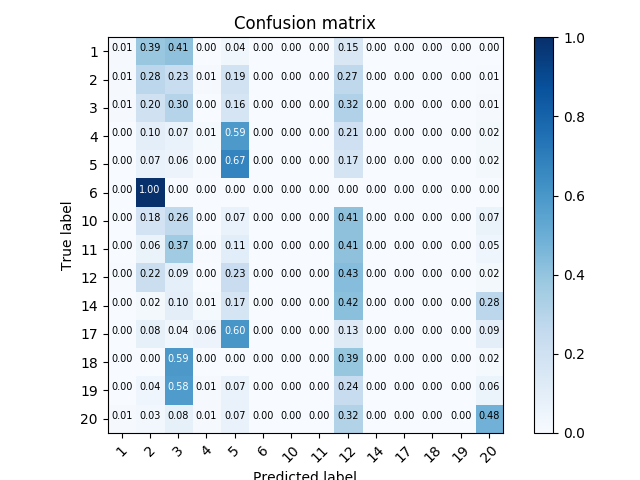

In [112]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
y_true = np.argmax(gt, axis=1)
y_pred = np.argmax(prediction, axis = 1)

real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=True)

In [113]:
somme = 0
for i in range (len(real_cnf_matrix)):    
    somme = somme + real_cnf_matrix[i,i] 
somme_t = sum(sum(real_cnf_matrix))
somme/somme_t


0.2994000827472073